## Exploration 9. Pneumonia Diagnosis Performance Improvement 🩺

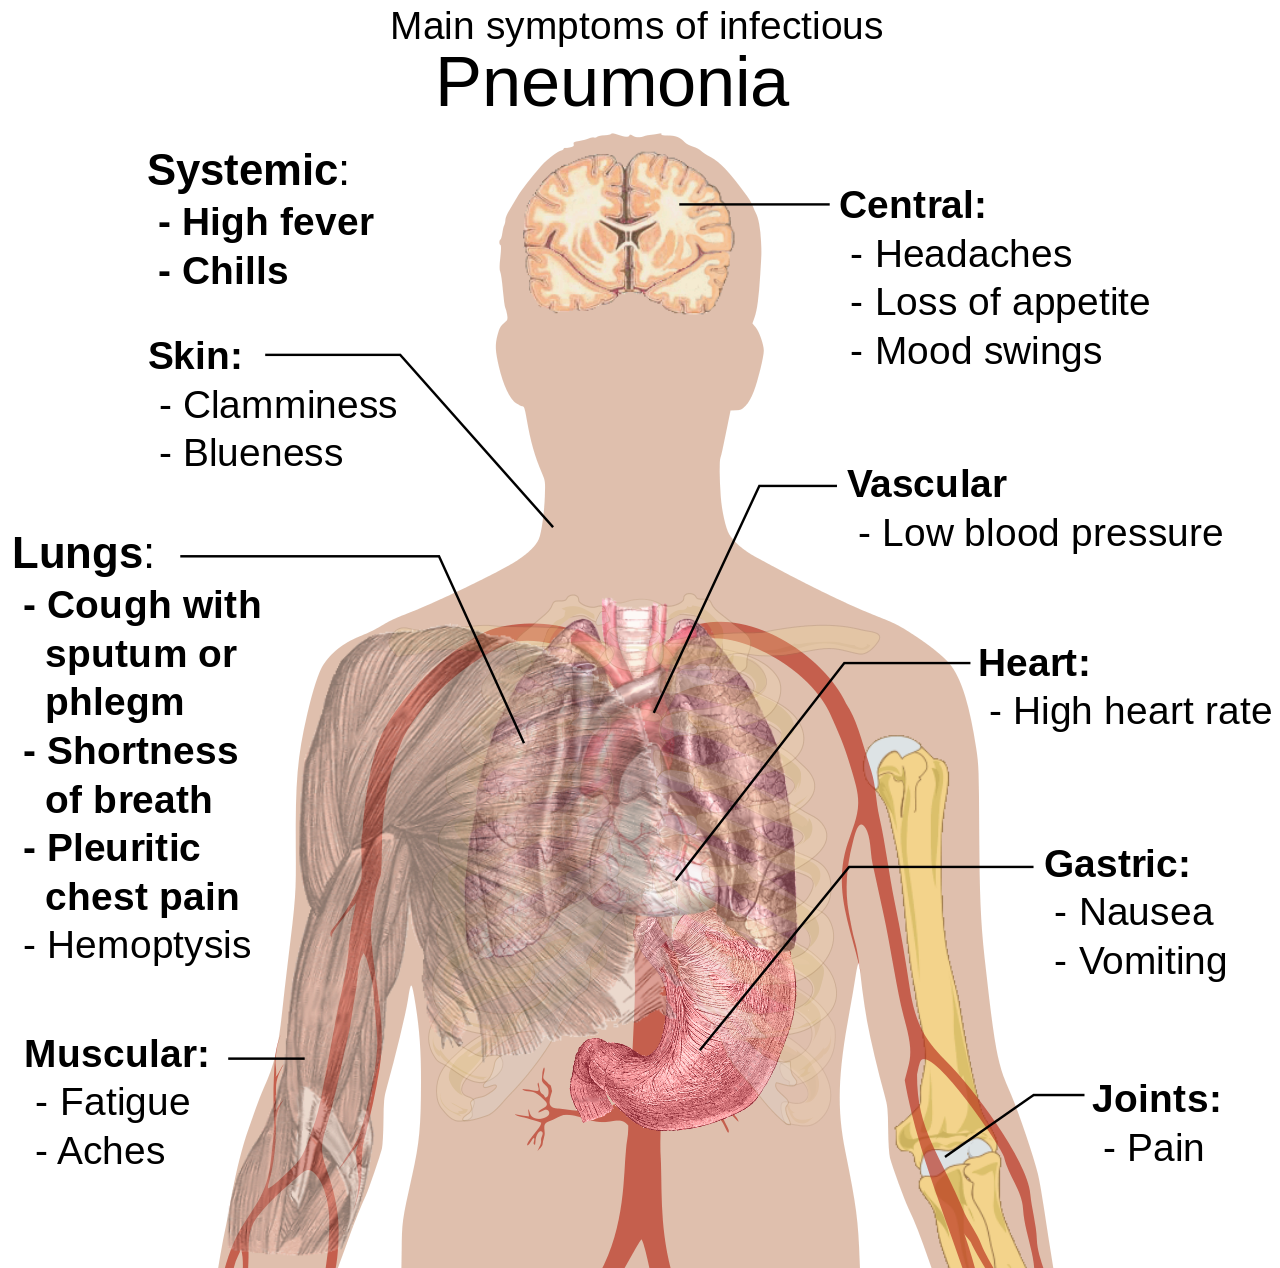

## Table of content

### 1. Introduction

* 1.1 What is Peunomia?
* 1.2 What is CNN?

### 2. Experiment Environment Set-up

* 2.1 Import Libraries
* 2.2 Create Variables

### 3. Load and View Data

* 3.1 Describtion of the Pneumonia Dataset
* 3.2 Load Data
* 3.3 Data Explorations
* 3.4 Data Visualization

### 4. Create and Train a Model

* 4.1 CNN Modeling (Normalization, Dropout)
* 4.2 Data Imbalance Handling
* 4.3 Train a Model
* 4.4 Interpret the results

### 5. Prediction Using Trained Model

### 6. Improving Accuracy

* 6.1 Modifying Parameters_1
* 6.2 Modifying Parameters_2
* 6.3 Data Augmentation_1
* 6.4 Data Augmentation_2
* 6.5 Data Augmentation_3
* 6.6 Modeling CNN
* 6.7 Model Fine-Tuning
* 6.8 Mix
* 6.9 Conclusion of Improving Accuracy

### 7. Retrospection

---

### 1. Introduction

### 1.1 What is Peunomia?

[폐렴(肺炎, pneumonia)](https://ko.wikipedia.org/wiki/%ED%8F%90%EB%A0%B4)은 폐에 염증이 생긴 상태로 중증의 호흡기 감염병이다. 세균을 통한 감염이 가장 많으며, 바이러스, 균류, 또는 기타 미생물도 원인이 될 수가 있다. 드물게는 알레르기 반응이나 자극적인 화학 물질을 흡입해 발생하기도 한다. 노인이나 어린아이, 혹은 전체적으로 상태가 안 좋은 환자들이나 기침 반사가 약한 사람들에게는 흡인성 폐렴이 발생한다 그리고 세균이 원인인 경우는 항생제로 치료를 할 수 있다. 항생제가 생기기 전에는 50~90%가 사망할 정도로 위험한 질환이었으나, 현재는 거의 사망하지 않는다. 1940년대에 항생제가 개발되기 전까지는 폐렴 환자의 1/3 정도가 사망하였다. 오늘날에는 적절한 의학적 치료로 폐렴 환자의 95% 이상이 회복된다. 그러나 일부 저개발국(개발 도상국)에서는 폐렴이 여전히 주요 사망 원인 중 하나이다. 독감이 심하게 진행되어 폐렴이나 기관지염을 일으키기도 한다.

### 1.2 What is CNN?

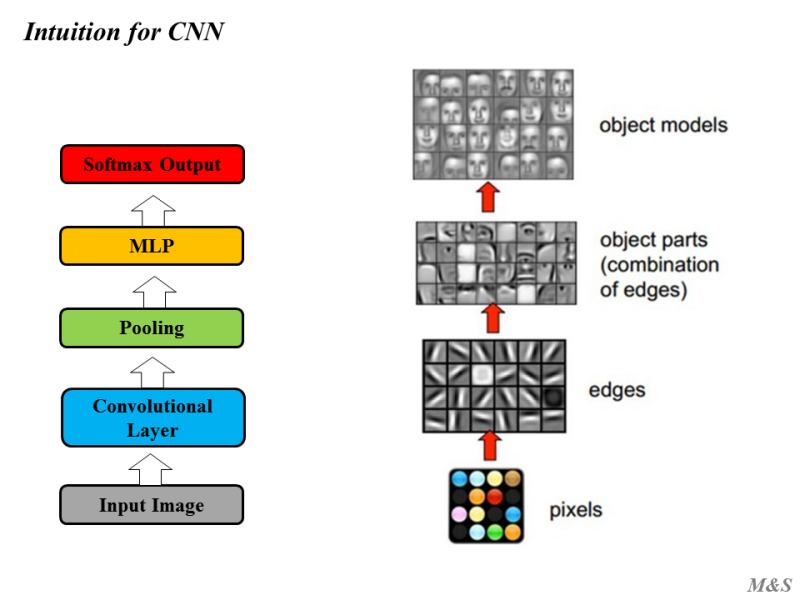
CNN은 이미지를 인식하기위해 패턴을 찾는데 특히 유용하다. 데이터에서 직접 학습하고 패턴을 사용해 이미지를 분류한다. 즉, 특징을 수동으로 추출할 필요가 없다. 이러한 장점때문에 자율주행자동차, 얼굴인식과 같은 객체인식이나 computer vision이 필요한 분야에 많이 사용되고 있다.
* https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sw4r&logNo=221344212601
* https://gruuuuu.github.io/machine-learning/cnn-doc/
* http://taewan.kim/post/cnn/

### 2. Experiment Environment Set-up

### 2.1 Import Libraries

In [1]:
import os, re
import random, math
import keras
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

### 2.2 Create Variable

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미한다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 16
EPOCHS = 50

print(ROOT_PATH)

/aiffel/aiffel


### 3. Load and View Data

### 3.1 Describtion of the Pneumonia Dataset

해당 데이터는 캐글의 Chest X-Ray Images이다. 데이터 구성은 `~/aiffel/chest_xray/data` 하위에 3개의 폴더 (train, test, val)로 구성되며, 각 이미지 카테고리 (폐렴 / 정상)에 대한 하위 폴더를 포함한다. 5,856 개의 X-Ray 이미지 (JPEG)와 2 개의 범주 (폐렴 / 정상)가 있다. 전체 데이터의 크기는 총 1.2GB 가량되며, 해당 이미지는 중국 광저우에 있는 광저우 여성 및 어린이 병원의 1~5 세 소아 환자의 흉부 X선 영상이다. 

### 3.2 Load Data

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

### 3.3 Data Explorations

In [4]:
print('The number of train set :',len(train_filenames))
print('The number of test set :',len(test_filenames))
print('The number of validation set :',len(val_filenames))

The number of train set : 5216
The number of test set : 624
The number of validation set : 16


* 각 데이터별 개수 비 : 89%(train), 10.7%(test), 0.3%(validation)
* validation data 수가 너무 적으므로 validation에 쓰일 data를 train data에서 가져온다.
* train, validation data를 모은 다음 train:validation을 80:20으로 나눈다.

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다. 
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다.
train_size = math.floor(len(filenames)*0.85)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print('The number of train set :',len(train_filenames))
print('The number of validation set :',len(val_filenames))

The number of train set : 4447
The number of validation set : 785


* validation data 개수 수정 후 각 데이터별 개수 : 4447개(train), 624개(test), 785개(validation)
* validation data 개수 수정 후 각 데이터별 개수 비율 : 75.9%(train), 10.7%(test), 13.4%(validation)

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1140
Pneumonia images count in training set: 3307


* train data set 내 정상, 폐렴 이미지 수 : 1140(정상), 3307(폐렴)
* CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 한다.
* 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정
*  test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 data set이어도 문제없다.

In [7]:
# tf.data 인스턴스 만들기
# tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해준다.
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
# train data set 개수 확인
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

# validation data set 개수 확인
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4447
Validating images count: 785


In [9]:
# 현재 이미지에는 라벨 데이터가 따로 없는 상태
# 파일 경로에 'NORMAL'이나 'PNEUMONIA'가 포함
# 이를 이용해 라벨 데이터를 만들어 주는 함수 생성

# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.
# 이미지의 사이즈를 줄임과 동시에 통일시켜준다.

# 이미지를 알맞은 형식으로 바꾼다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어온다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
# train data, validation data set 만들기
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# data 변환 여부 확인하기
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


`train_ds.take(1)` : 하나의 데이터만 가져온다는 의미

In [13]:
# test data set에도 위와 동일하게 적용
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# tf.data 파이프라인을 이용하여 prepare_for_training() 함수 정의
# shuffle() : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택
# repeat() : epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 사용 가능
# batch() : BATCH_SIZE에서 정한 만큼의 배치로 주어짐
# prefetch() : 학습 데이터를 나눠서 읽어옴. 첫 번째 데이터가 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비. 리소스의 유휴 상태를 줄일 수 있음.

def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

### 3.4 Data Visualization

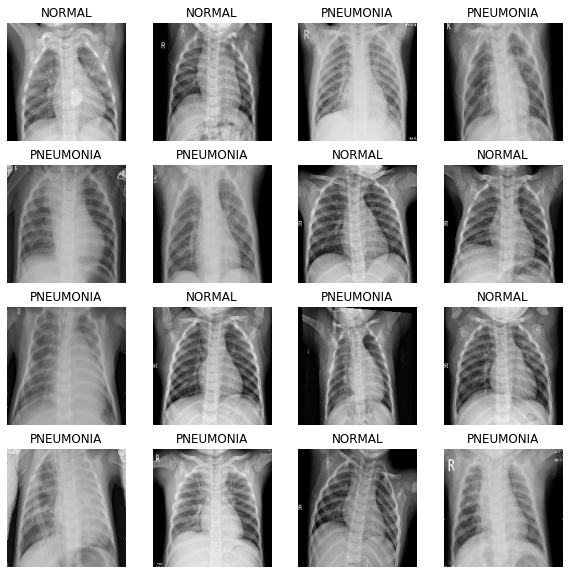

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### 4. Create and Train a Model

### 4.1 CNN Modeling (Normalization, Dropout)

In [16]:
# Convolution block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
# Dense Block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 4.2 Data Imbalance Handling

* 'Normal'과 폐렴에서 'Pneumonia' 중에 'Pneumonia' 데이터가 많이 있었다. 
* 데이터를 학습할 때 imbalance한 데이터의 경우 학습 효과가 좋지 않을 수 있다. 
* 이런 문제들을 해결하는 방법으로 `Weight balancing`이라는 테크닉이 사용된다.
* `Weight balancing` : training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [19]:
# weight_for_0은 'Normal' 이미지에 사용할 weight 세팅
# weight_for_1은 'Pneumonia' 이미지에 사용할 weight 세팅
# 이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정

weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


### 4.3 Train a Model

In [20]:
# 미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss 사용
# optimizer로 'adam' 사용
# 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'사용

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
# callback으로 훈련 중 가장 최상의 점수를 낸 모델 저장
es = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
cb = tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only = True)

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[cb, es]
    )

Epoch 1/50
277/277 [==============================] - 64s 183ms/step - loss: 0.4073 - accuracy: 0.7994 - precision: 0.9499 - recall: 0.7709 - val_loss: 0.8061 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 2/50
277/277 [==============================] - 50s 181ms/step - loss: 0.2489 - accuracy: 0.8973 - precision: 0.9702 - recall: 0.8892 - val_loss: 1.2548 - val_accuracy: 0.7334 - val_precision: 0.7334 - val_recall: 1.0000
Epoch 3/50
277/277 [==============================] - 51s 183ms/step - loss: 0.2150 - accuracy: 0.9210 - precision: 0.9748 - recall: 0.9174 - val_loss: 0.0973 - val_accuracy: 0.9694 - val_precision: 0.9911 - val_recall: 0.9670
Epoch 4/50
277/277 [==============================] - 51s 183ms/step - loss: 0.1839 - accuracy: 0.9235 - precision: 0.9802 - recall: 0.9158 - val_loss: 0.1050 - val_accuracy: 0.9617 - val_precision: 0.9892 - val_recall: 0.9583
Epoch 5/50
277/277 [==============================] - 52s 187ms/step - loss: 0.1693 - accura

### 4.4 Interpret the results

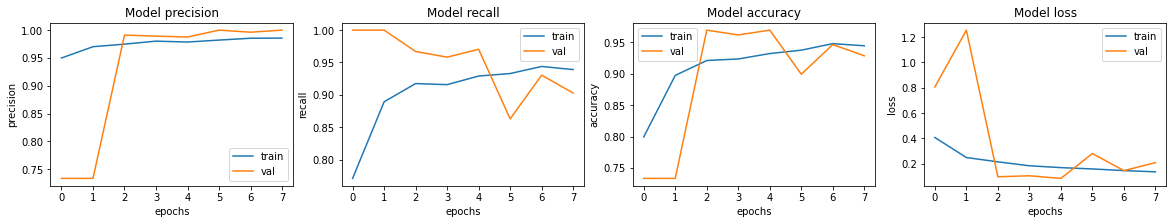

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 5. Prediction Using Trained Model

In [24]:
best_model = keras.models.load_model('best_model.h5')

In [25]:
loss, accuracy, precision, recall = best_model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 115ms/step - loss: 0.6288 - accuracy: 0.7580 - precision: 0.7234 - recall: 0.9923
Loss: 0.6287606358528137,
Accuracy: 0.7580128312110901,
Precision: 0.7233644723892212,
Recall: 0.9923076629638672


|Item|Result|
|:---:|:---:|
|Loss|0.629|
|Accuracy|0.758|
|Precision|0.723|
|Recall|0.992|

* 모델이 학습할 때마다 결과값으로 출력되는 정확도의 차이가 많이 난다. (약 65~80%까지)

### 6. Improving Accuracy

### 6.1 Modifying Parameters_1

* Batch size = 16 → 8
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|0.560|
|Accuracy|0.795|
|Precision|0.759|
|Recall|0.985|

* Refer to file `Attachment 1.PneumoniaDetection_Parameter.ipynb` for detail

### 6.2 Modifying Parameters_2

* Batch size = 16 → 20
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|0.914|
|Accuracy|0.771|
|Precision|0.733|
|Recall|0.997|

* Refer to file `Attachment 2.PneumoniaDetection_Parameter2.ipynb` for detail

### 6.3 Data Augmentation_1

* The angle of the picture is randomly tilted by 30 degrees.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|0.537|
|Accuracy|0.840|
|Precision|0.797|
|Recall|0.997|

* Refer to file `Attachment 3.PneumoniaDetection_Augmentation.ipynb` for detail

### 6.4 Data Augmentation_2

* The contrast of the image was improved through Histogram Equalization.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|1.112|
|Accuracy|0.760|
|Precision|0.735|
|Recall|0.962|

* Refer to file `Attachment 4.PneumoniaDetection_Augmentation2.ipynb` for detail

### 6.5 Data Augmentation_3

* Through the Histogram Equalization, the ratio was made 1:1 by combining the original image data and the image data subjected to agumentation.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|1.930|
|Accuracy|0.771|
|Precision|0.733|
|Recall|0.995|

* Refer to file `Attachment 5.PneumoniaDetection_Augmentation3.ipynb` for detail

### 6.6 Modeling CNN

* Try new modeling and training.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|3.624|
|Accuracy|0.739|
|Precision|0.706|
|Recall|0.997|

* Refer to file `Attachment 6.PneumoniaDetection_Model.ipynb` for detail

### 6.7 Model Fine-Tuning

* Control the learning speed through fine-tuning.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|1.158|
|Accuracy|0.788|
|Precision|0.753|
|Recall|0.985|

* Refer to file `Attachment 7.PneumoniaDetection_Tuning.ipynb` for detail

### 6.8 Mix

* The angle of the picture is randomly tilted by 30 degrees.
* Through the Histogram Equalization, the ratio was made 1:1 by combining the original image data and the image data subjected to agumentation.
* Control the learning speed through fine-tuning.
* Through `callbacks.ModelCheckpoint`, the model that makes the best verification score is saved and predictions are made on the test data.

|Item|Result|
|:---:|:---:|
|Loss|0.481|
|Accuracy|0.796|
|Precision|0.762|
|Recall|0.979|

* Refer to file `Attachment 8.PneumoniaDetection_Mix.ipynb` for detail

### 6.9 Conclusion of Improving Accuracy

* 정확도가 약 73~84%정도로 루브릭인 85%를 만족하지는 못했다. 

* Batch size 변경
  * Batch size를 변경하여 학습했을 때는 변경하기 전보다 높은 정확도를 보이긴 하나 만족 할만한 정확도를 보이지 않았다.

* Augmentation(기울이기)
  * 사진을 랜덤하게 30도 기울이는 augmentation을 진행했을 때 약 84%로 제일 높은 정확도를 보였다.
  * train, val, test data의 이미지에서 몸이 기울어져서 찍힌 X-ray들이 보였는데, 이러한 X-ray에 대해 모델이 어느정도 학습을 좀 더 했다고 판단할 수 있을 것 같다.

* Augmentation(명암대비)
  * 육안으로 봤을 때 폐렴환자의 X-ray와 정상인의 X-ray를 비교했을 때 큰 차이를 보이지 않는 X-ray들이 많이 있었다.
  * 그래서 폐의 염증 부분을 더 부각시키기 위해 이미지에 명암 대비를 적용시켰다.
  * Augmentation을 진행한 이미지들로만 학습을 했기 때문에 대비를 주기 전의 정확도와 비슷하거나 더 낮게 나올 수 있을 것이라 예상할 수 있으며, 실제로 그렇게 결과가 나타나기도 했다. (변경 전 Accuracy : 0.758, 변경 후 Accuracy : 0.760)

* Augmentation(명암대비, 원데이터와 합치기)
  * 위 문제를 해결하기 위해 Augmentation data와 원래 data를 합쳤다.
  * data를 합침으로써 data 수는 2배로 늘어나고, Augmentation data:원래 data = 1:1이 된다.
  * 정확도는 0.77로 다른 방법들과 비슷한 수준을 보이나 Loss가 1.930으로 증가한 것으로 보아 augmentation이 큰 도움이 되지 못하는 듯하다.
  * 아래 논문을 참고해보면, Augmentation data와 원래 data의 비율은 예측에 영향을 줄 수 있는 것으로 파악되며, 적합한 비율은 하나하나 적용시켜가며 찾아봐야 한다.

* Agumentation 참고 논문 : https://arxiv.org/pdf/1810.10863.pdf (찾아본 논문 중 정리가 제일 잘 되어 있는 듯)

* Modeling CNN
  * 직접 CNN 모델을 만들어 보았다. 
  * 형편없으므로 결과 정리는 skip한다.

* Tuning(학습률 변경)
  * epoch를 돌 때마다 최적의 weight를 찾아 적용시킬 수 있도록 학습률 변경을 적용시켜보았다.
  * 정확도는 0.788, 로스는 1.158로 다른 방법들과 큰 차이를 확인할 수는 없었으나 그래프를 보았을 때 정확도가 점진적으로 증가하는 양상을 확인할 수 있다. 

* Mix(위 방법 합쳐보기)
  * 이미지 기울이기, 명암 대비 이미지 1:1 비율로 합치기, 학습률 변경 3가지를 모두 같이 합쳐서 학습 진행
  * 정확도는 0.796, 로스는 0.481로 나왔다. 정확도는 다른 방법들과 큰 차이가 없었으나, 로스는 다른 것들보다 많이 낮아진 것을 확인할 수 있다.
  * 앞의 방법들은 코드를 실행할 때마다 정확도가 널띄는 것을 볼 수 있었다.(최대, 최소값의 차이가 많이 난다.)
  * 이 방법을 사용 시 정확도가 78~80%정도로 안정적이게 출력됨을 확인했다.
  * 로스의 경우 다른 방법들보다 낮게 나왔는데, 이는 학습된 모델이 test data에도 강건하게 반응하고 있다고 볼 수 있을 것 같다.

### 7. Retrospection

### 7.1 What was difficult

* 루브릭 맞추기 너무 어렵다😥

### 7.2 What I found out

### 7.1.1 Functions

* `from_tensor_slices()`

https://cyc1am3n.github.io/2018/09/13/how-to-use-dataset-in-tensorflow.html
* `tf.data.experimental.cardinality()`

https://www.tensorflow.org/api_docs/python/tf/data/experimental/cardinality
* `tf.strings.split()`

https://www.tensorflow.org/api_docs/python/tf/strings/split
* `map_func`

https://www.tensorflow.org/api_docs/python/tf/data/Dataset

https://www.tensorflow.org/guide/data#dataset_structure

https://ahnjg.tistory.com/32


https://www.tensorflow.org/guide/data?hl=ko

* cardinality(카널리티)

https://itholic.github.io/database-cardinality/

### 7.1.2 Concept Summary

* data argumentation

https://tensorflow.google.cn/tutorials/images/data_augmentation#%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A6%9D%EA%B0%95_2

* 모델 학습률

https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

### 7.3 What I want to know more about

* 현재까지 적용해본 방법들의 결과들을 살펴보면 정확도는 낮은데, Recall은 굉장히 높게 나온다.
* 이 결과를 해석해보면 학습된 모델이 test data의 X-ray 대부분을 폐렴환자 X-ray로 분류하고 있다고 볼 수 있다. (아래 표 참고)
* 이는 모델이 정상인과 폐렴환자의 X-ray 이미지에서 차이를 제대로 학습하지 못했다고 볼 수 있다.

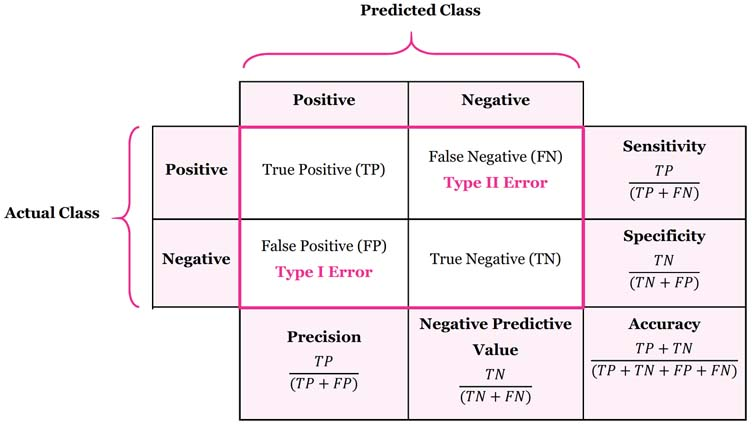

* 위 해석이 옳은 해석인지 판단하기 위해 아래를 추가적으로 더 진행해볼 수 있을 것 같다.
  * 명확하게 "폐렴환자 X-ray다"라고 판단이 가능한 데이터 사용하기 (사용한 X-ray 데이터는 육안으로 봐도 판별이 안 되는 것들이 너무 많았다.)
  * x-ray 명암 대비를 적절히 줘서 폐렴 부분이 부각될 수 있도록 augmentation 진행 (위에서 한 것은 대비 수준을 따로 설정하지 않았다.)
  * 모델이 이미지의 특성을 잡아낼 위치를 특정시켜줘서 그 부분에서만 특성을 잡을 수 있도록 해준다. (따로 방법이 있을 듯)

### 7.4 Self-Resolution

* 많은 시도들을 해보았지만 의미있는 결과값을 얻을 수는 없었다.
* 하지만 이런저런 시도들을 해보면서 더 많은 것을 공부할 수 있었던 시간이 된 것 같아 뿌듯하다😁

#### [Attachments]

* Attachment 1.PneumoniaDetection_Parameter
* Attachment 2.PneumoniaDetection_Parameter2
* Attachment 3.PneumoniaDetection_Augmentation
* Attachment 4.PneumoniaDetection_Augmentation2
* Attachment 5.PneumoniaDetection_Augmentation3
* Attachment 6.PneumoniaDetection_Model
* Attachment 7.PneumoniaDetection_Tuning
* Attachment 8.PneumoniaDetection_Mix.ipynb

#### [References]

* matrix

https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html